# **Limpieza y Organización de Datos PS3**
<br>
Nicolas Lozano, Jhan Pulido, Gerardo Rendon, Samuel Narvaez
<br>
2025-05-06

## Limpiamos ambiente y cargamos paquetes

In [124]:
rm(list = ls())

require(pacman)

p_load(
  "ggplot2",
  "tidyverse",
  "dplyr",
  "visdat",
  "stargazer",
  "leaflet"
)

# Set working directory to the project root
while (tail(strsplit(getwd(), "/")[[1]], 1) != "202510-MLBD-PS3") {
  setwd("..")
}

getwd()

options(
  repr.plot.width  = 10,   # inches  (default is 7)
  repr.plot.height = 6,    # inches  (default is 5)
  repr.plot.res    = 120   # DPI; larger → sharper but heavier files
)

[1] "c:/Users/NicolasLozano/OneDrive - Universidad de los andes/UNIVERSIDAD/9. NOVENO SEMESTRE/BIG DATA/ProblemSets/202510-MLBD-PS3"

## Cargue de datos

In [125]:
test <- read.csv(
  "stores\\raw\\test.csv"
)

train <- read.csv(
  "stores\\raw\\train.csv"
)

## Organizamos los datos

### Corregimos los tipos de variables

In [126]:
train <- train %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

test <- test %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

### Analizamos Missing Values

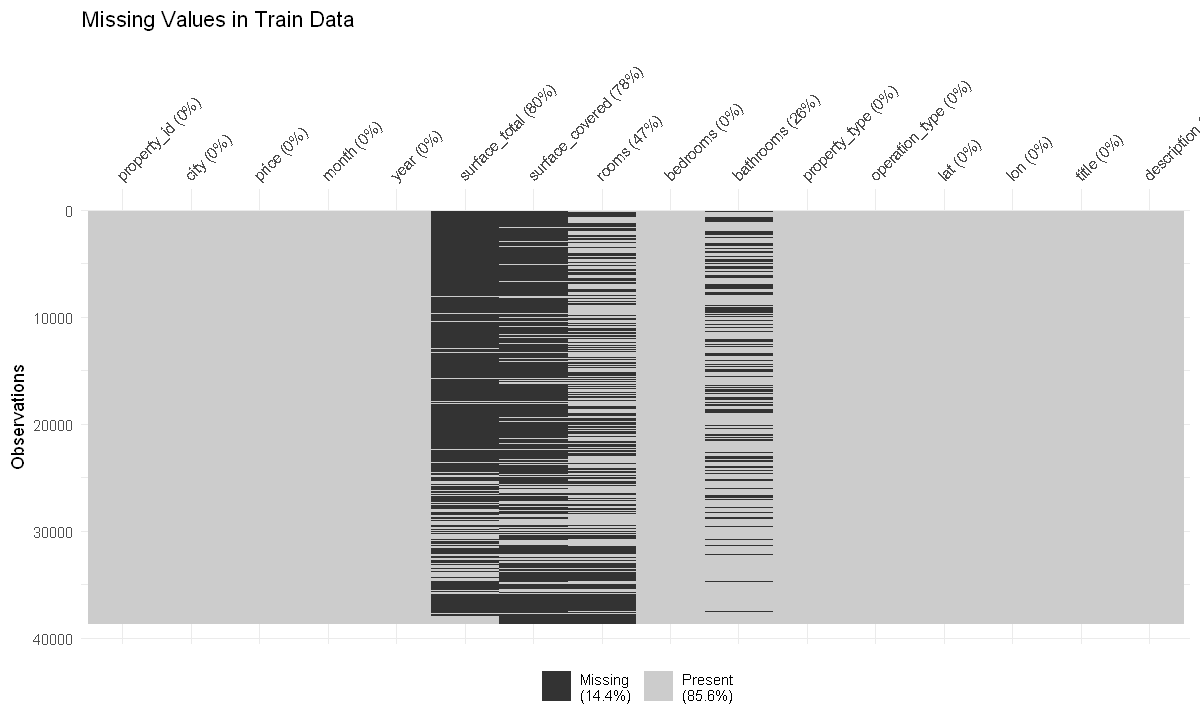

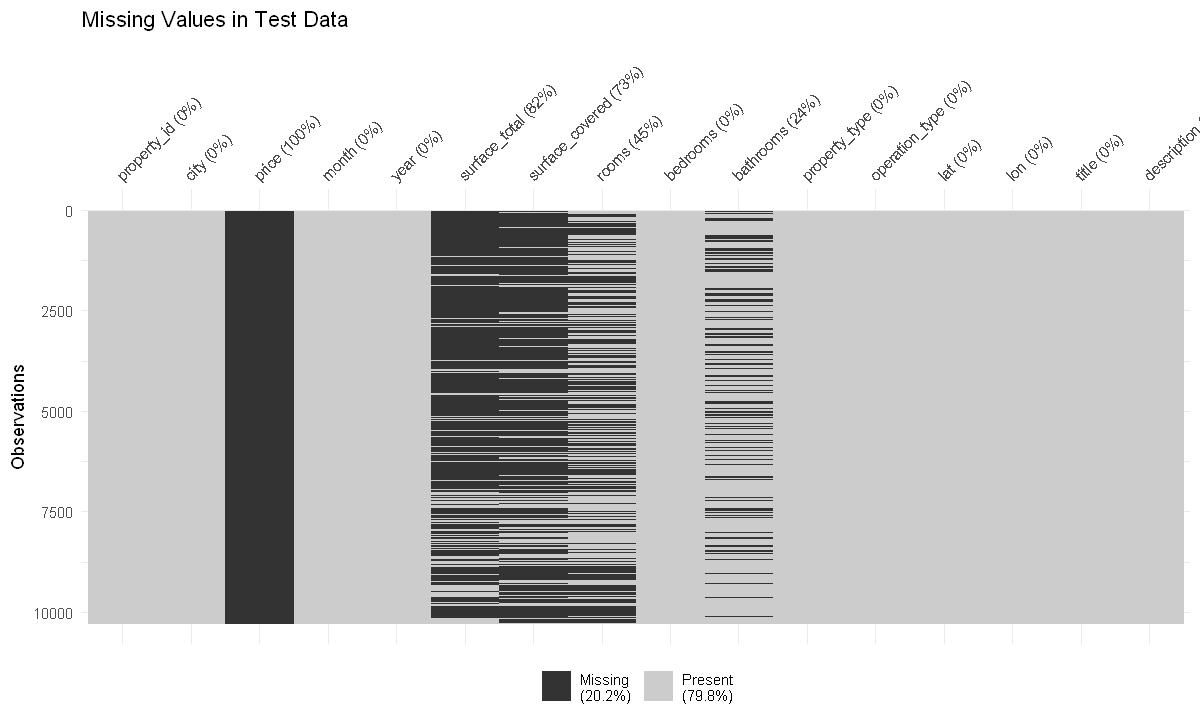

In [127]:
train  <- train %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

test  <- test %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

miss_train  <- vis_miss(train) +
            ggtitle("Missing Values in Train Data")

miss_test  <- vis_miss(test) +
            ggtitle("Missing Values in Test Data")

miss_train
miss_test

Hay un gran numero de missing values en la variables `surface_total`, `surface_covered`, `rooms` y `bathrooms`

### Imputamos valores para variables con gran número de missing values

Para habitaciones y baños usamos la moda al ser variables discretas

In [128]:
train  <- train %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms)
    )

test  <- test %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms)
    )

In [129]:
train <- train %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

test <- test %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

Al imputar utilizando la moda, especialmente para el caso de la variable `rooms` donde el procentaje de valores faltantes esta entre 45% y 47%, se podría estar sesgando la distribución. Se sugiere a futuro escoger otros métodos de imputación que no introduzcan este problema.

Para las variables de superficies al ser variables continuas imputamos utilizando la mediana y un método de regresión.

Imputación con la mediana

In [130]:
train_med  <- train
train_reg <- train
test_med  <- test
test_reg <- test

In [131]:
train_med  <- train_med  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

test_med  <- test_med  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

Imputación con regresión

In [132]:
linear_imput_model_covered  <- lm(
    surface_covered ~ 
        property_type + rooms + bathrooms + bedrooms + price,
    data = train_reg, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total ~ 
        property_type + rooms + bathrooms + bedrooms + price,
    data = train_reg, na.action = na.exclude
)

train_reg$pred_total  <- predict(
    linear_imput_model_total,
    newdata = train_reg
)

train_reg$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = train_reg
)

linear_imput_model_covered  <- lm(
    surface_covered ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test_reg, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test_reg, na.action = na.exclude
)

test_reg$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = test_reg
)

test_reg$pred_total  <- predict(
    linear_imput_model_total,
    newdata = test_reg
)

train_reg  <- train_reg  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, pred_covered, surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, pred_total, surface_total)
            )

test_reg  <- test_reg  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, pred_covered, surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, pred_total, surface_total)
            )


Warning message in predict.lm(linear_imput_model_covered, newdata = test_reg):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


Dejar las variables `rooms`, `bathrooms` y `bedrooms` como factores arroja error, debido al gran número de missing values en las variables dependientes. Por esto se dejan como enteros. Ahora miramos las distribuciones para las variables imputadas.

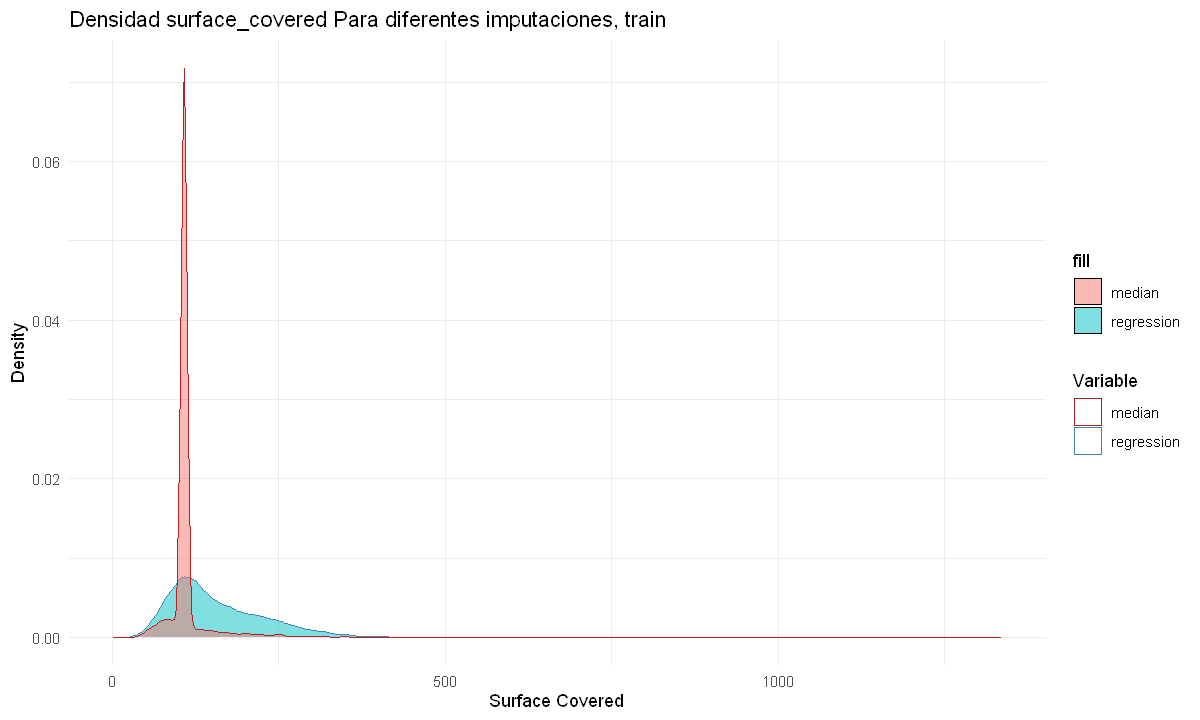

In [133]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = surface_covered,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train_med,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",                     # legend title
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

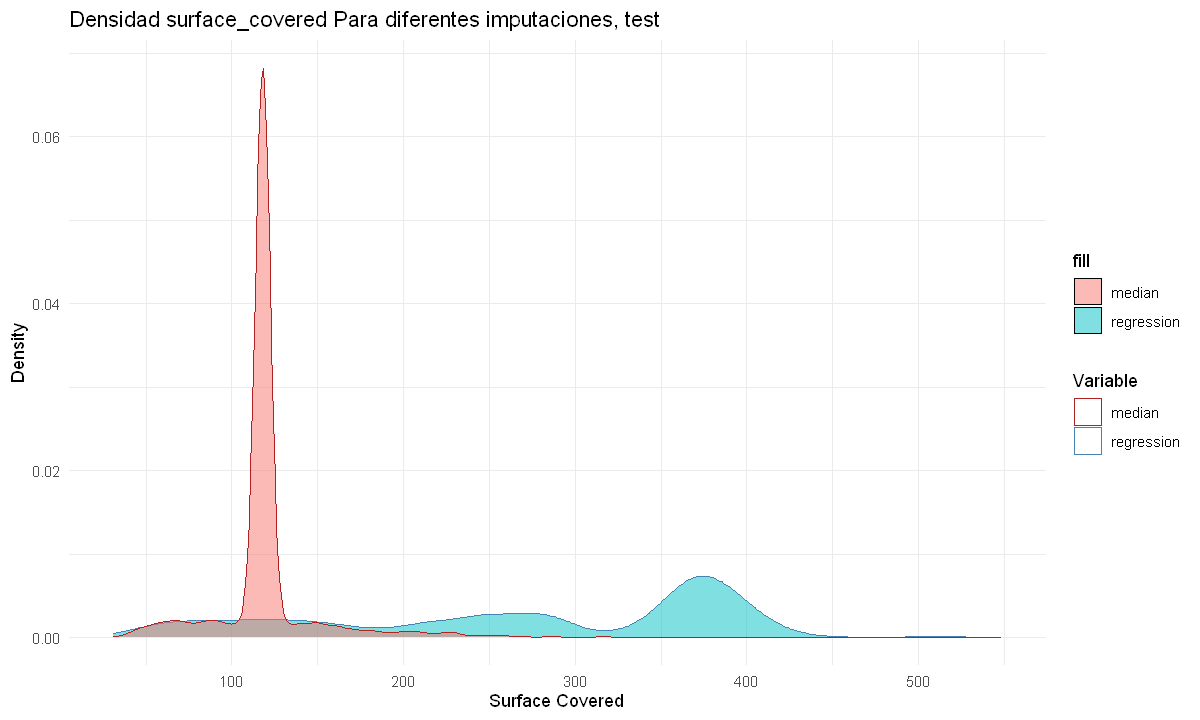

In [134]:
ggplot() +
    geom_density(
        data = test_reg,
        aes(
            x = surface_covered,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test_med,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

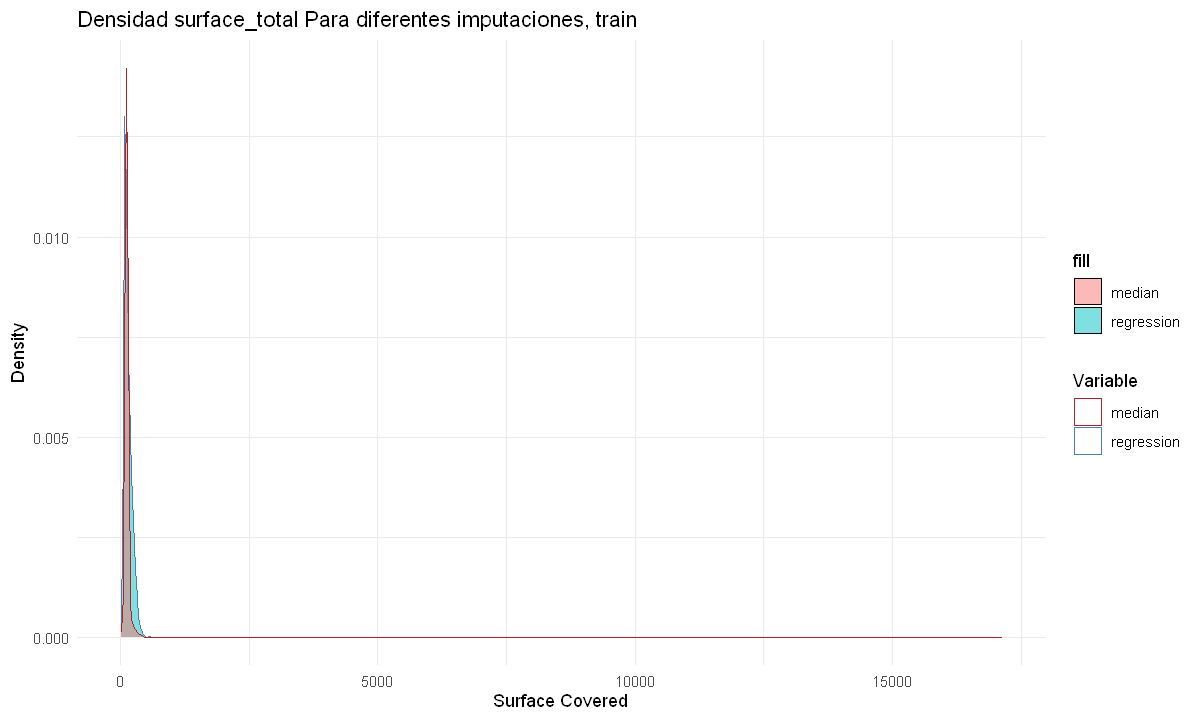

In [135]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = surface_total,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train_med,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

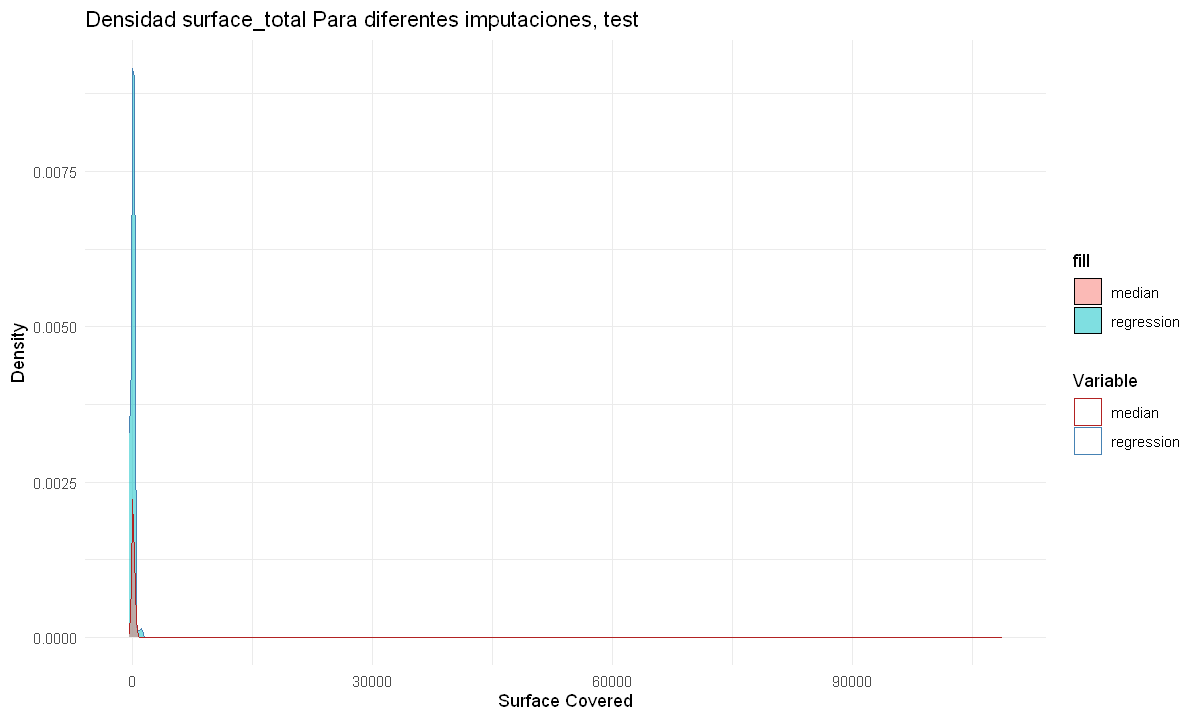

In [136]:
ggplot() +
    geom_density(
        data = test_reg,
        aes(
            x = surface_total,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test_med,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

### Outliers

En los histogramas anteriores podemos ver que hay poroblemas de valores atipicos, especialmente para `surface_total`. Para manejar estos valores atípicos creamos la variable `precio_por_mt2` que debería solucionar el problema en ambas variables.

Precio Por mt2, area total imputada con la mediana

In [137]:
train_med <- train_med %>%
  mutate(precio_por_mt2 = round(price / surface_total, 0))%>%
  mutate(precio_por_mt2  =precio_por_mt2/1000000 ) 
stargazer(train_med["precio_por_mt2"], type="text")


Statistic        N    Mean  St. Dev.  Min   Max  
-------------------------------------------------
precio_por_mt2 38,644 5.408  2.482   0.020 40.450
-------------------------------------------------


Miramos el histograma

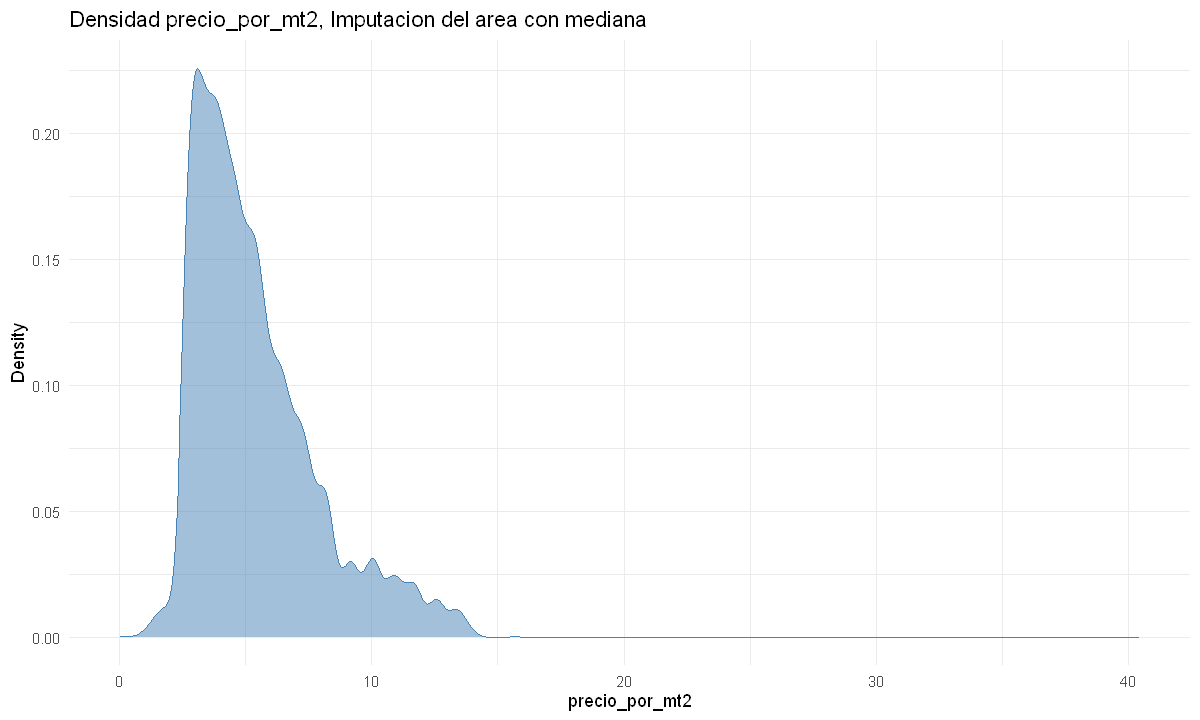

In [138]:
ggplot() +
    geom_density(
        data = train_med,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con mediana",
        y = "Density"
    ) +
    theme_minimal() 

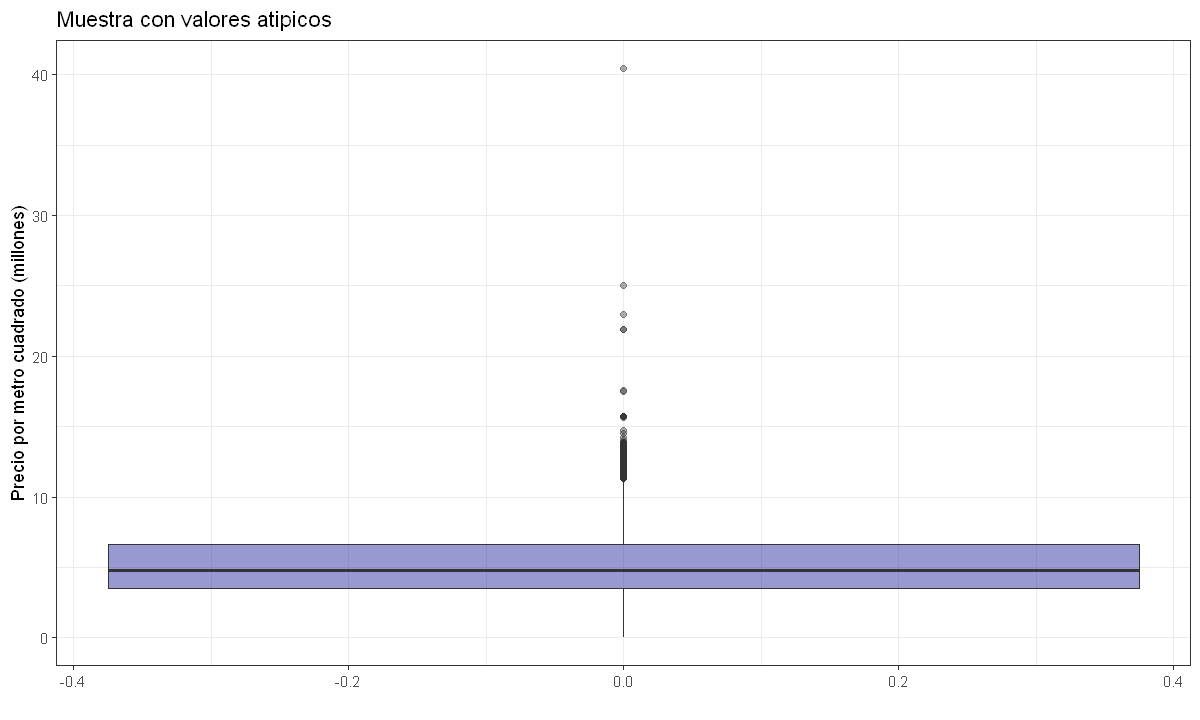

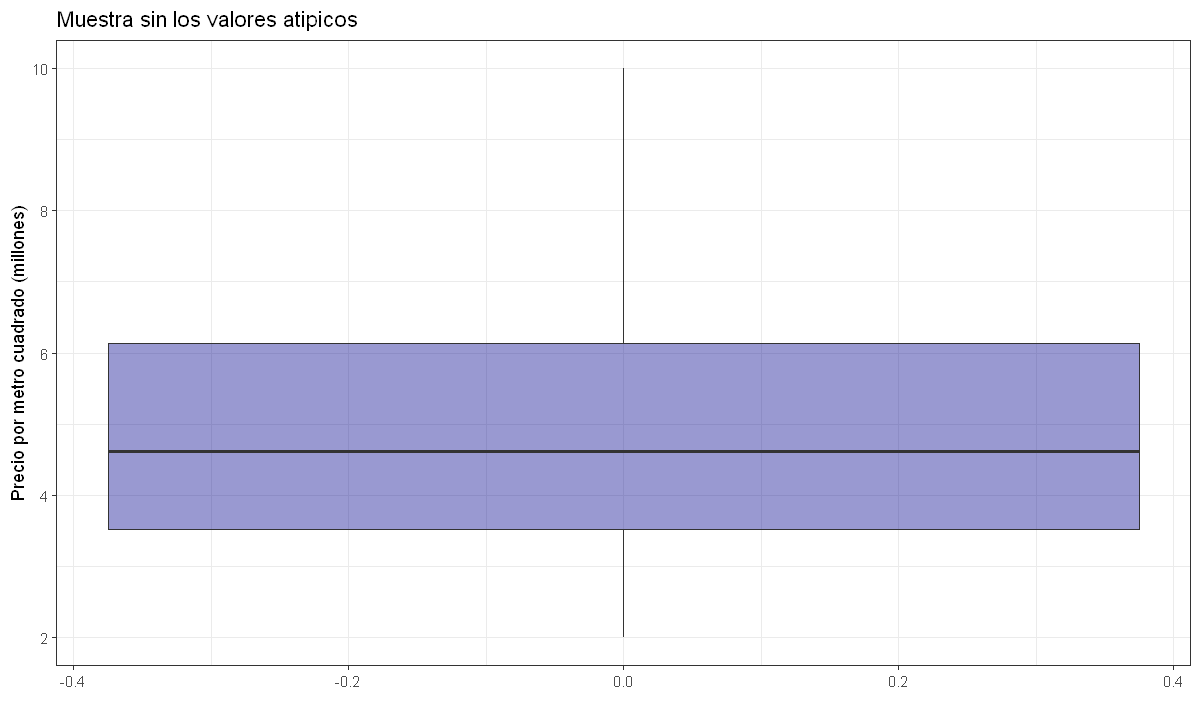

In [139]:
low <- round(mean(train_med$precio_por_mt2) - 2*sd(train_med$precio_por_mt2))
up <- round(mean(train_med$precio_por_mt2) + 2*sd(train_med$precio_por_mt2))
perc1 <- unname(round(quantile(train_med$precio_por_mt2, probs = c(.01)),2))

Graph_1 <- train_med %>%
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra con valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_2 <- train_med %>%
  filter(between(precio_por_mt2, perc1,  up)) %>% 
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra sin los valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_1
Graph_2

train_med <- train_med %>% filter(between(precio_por_mt2, perc1, up))

Miremos otra vez los histogramas de área.

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


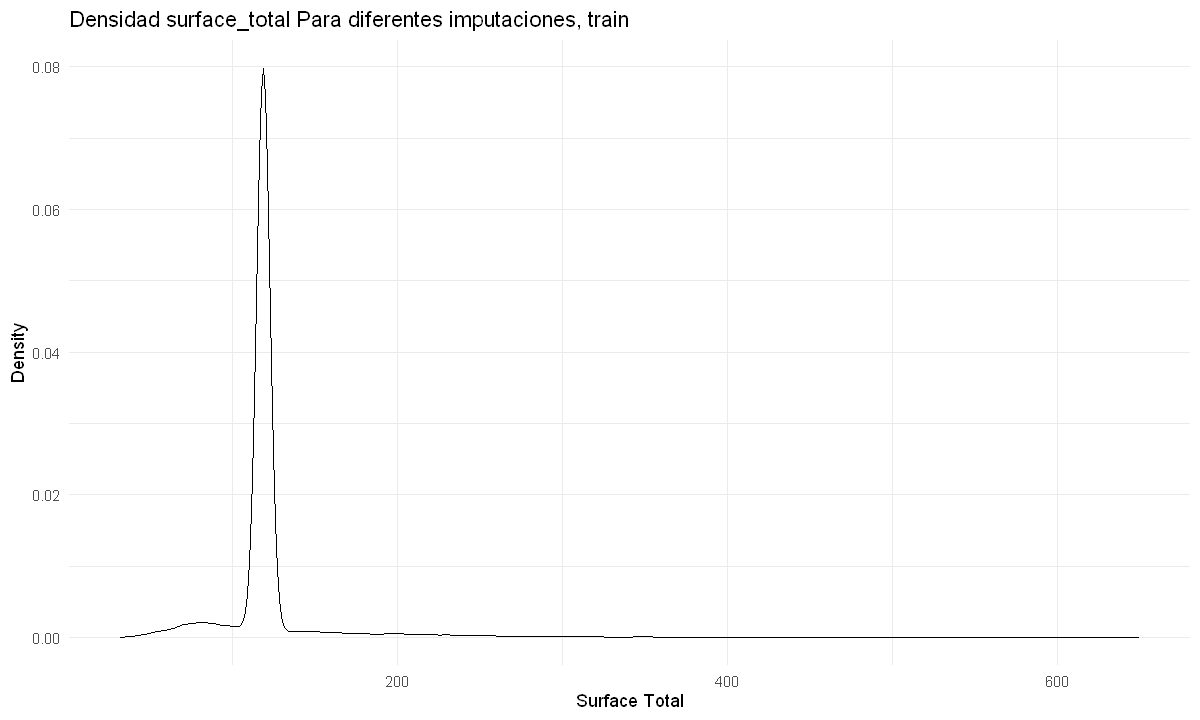

In [140]:
ggplot() +
    geom_density(
        data = train_med,
        aes(
            x = surface_total
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Total",
        y = "Density"
    ) +
    theme_minimal() 

Miramos histograma del precio por mt2 despues de filtrar outliers

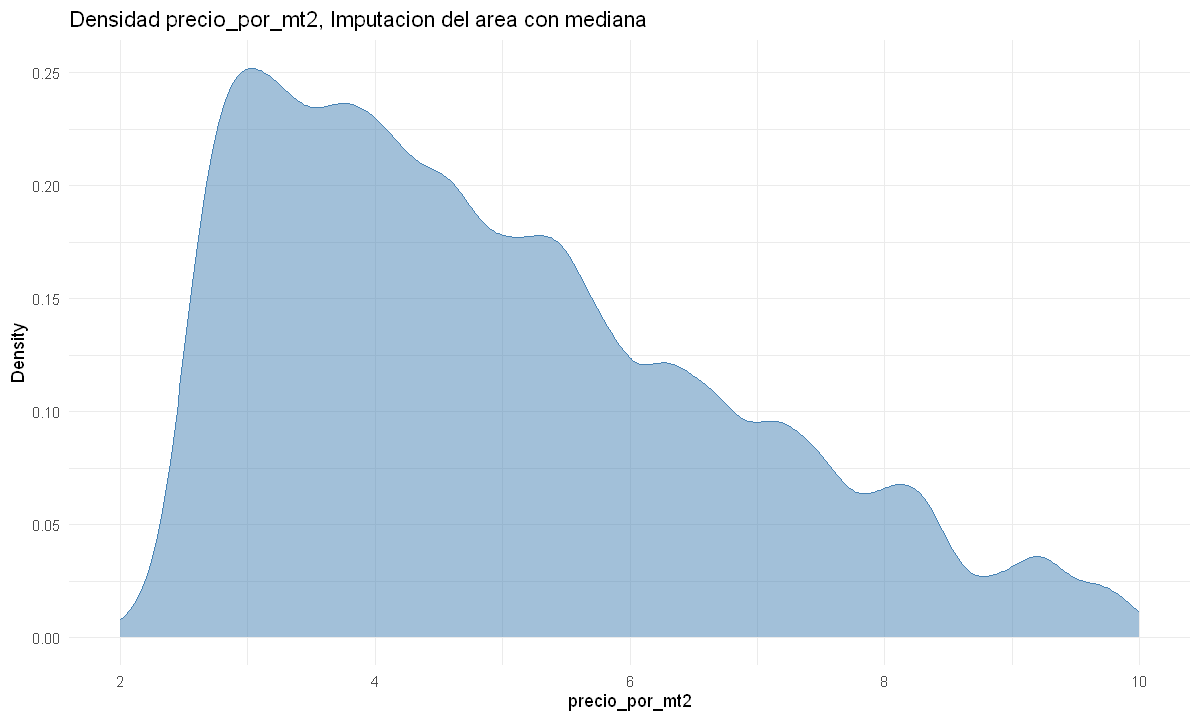

In [141]:
ggplot() +
    geom_density(
        data = train_med,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con mediana",
        y = "Density"
    ) +
    theme_minimal() 

Precio por mt2 area imputada con regresion

In [142]:
train_reg <- train_reg %>%
  mutate(precio_por_mt2 = round(price / surface_total, 0))%>%
  mutate(precio_por_mt2  =precio_por_mt2/1000000 ) 
stargazer(train_reg["precio_por_mt2"], type="text")


Statistic        N    Mean  St. Dev.  Min   Max  
-------------------------------------------------
precio_por_mt2 38,644 4.956  1.520   0.020 40.450
-------------------------------------------------


Miramos el histograma del precio por metro cuadrado

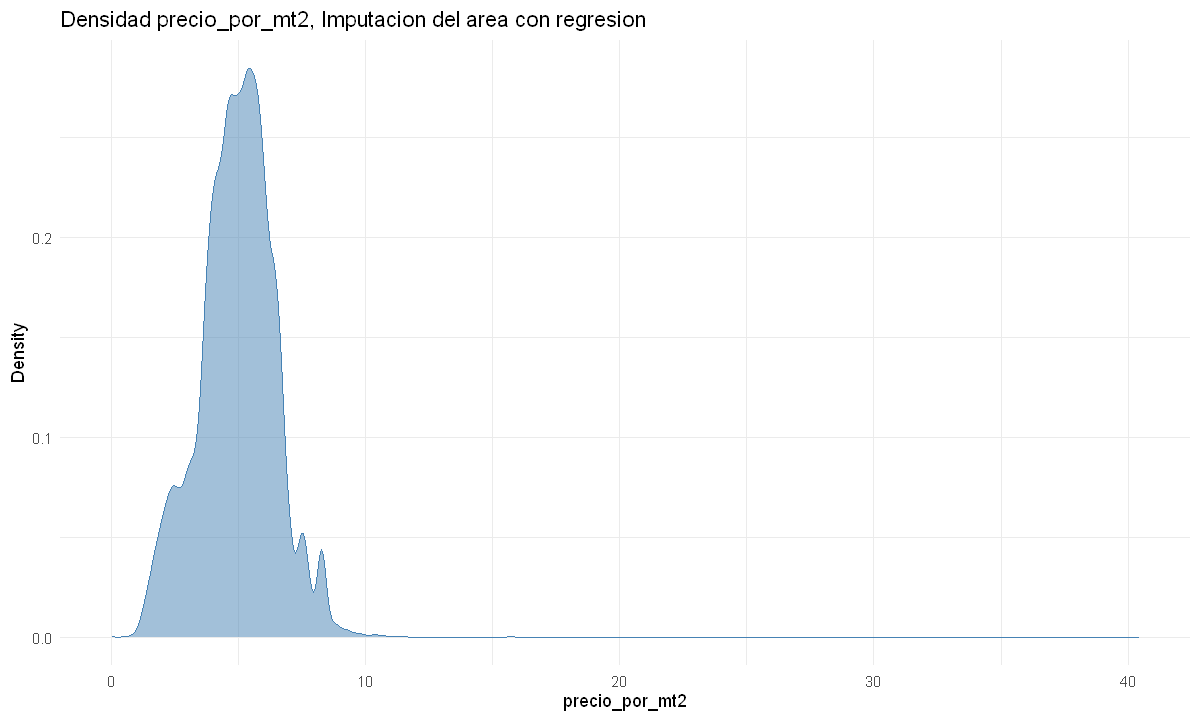

In [143]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con regresion",
        y = "Density"
    ) +
    theme_minimal() 

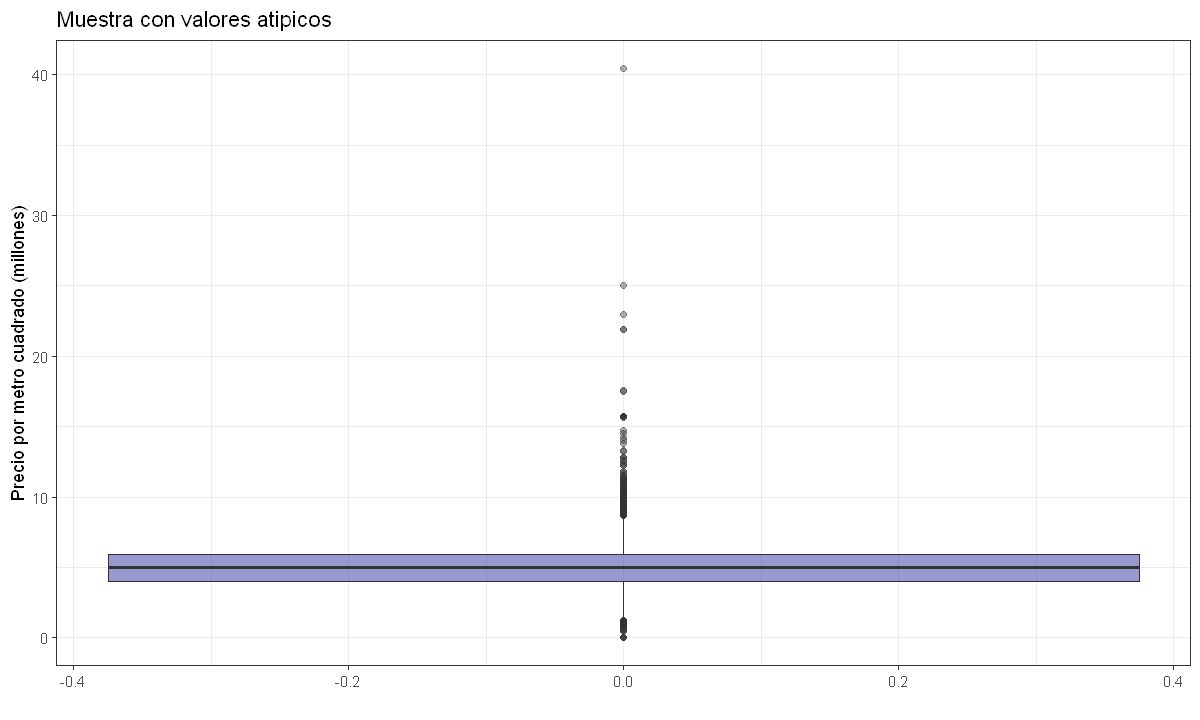

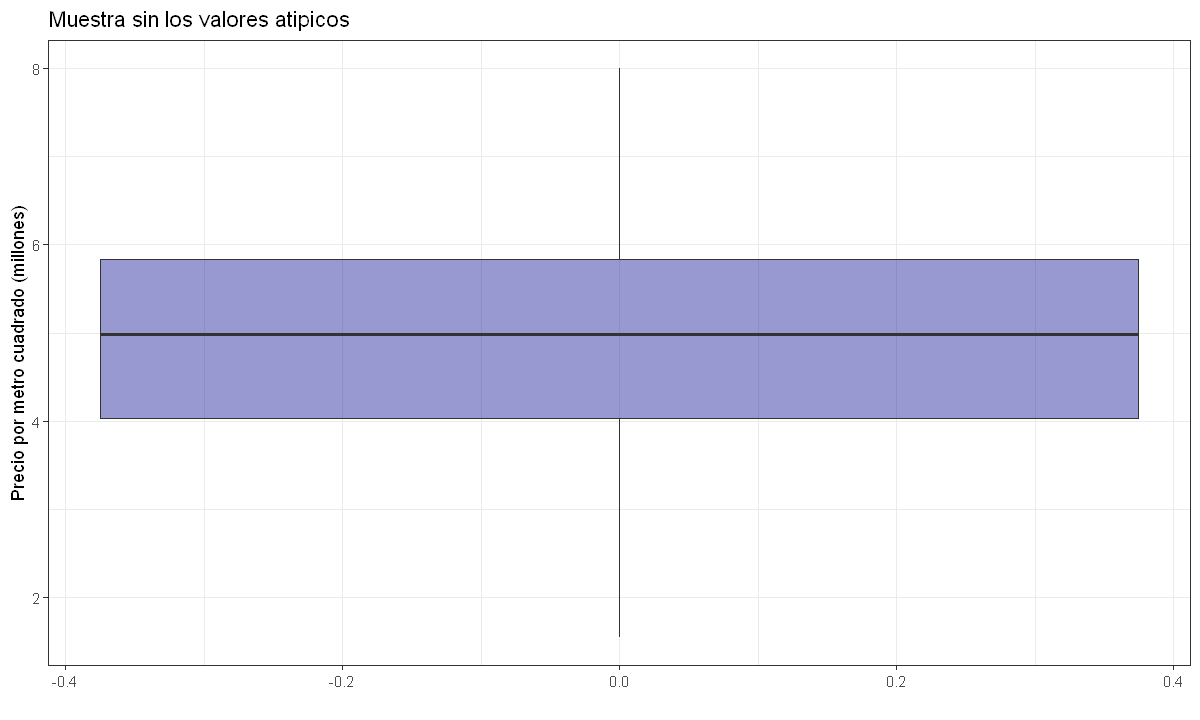

In [144]:
low <- round(mean(train_reg$precio_por_mt2) - 2*sd(train_reg$precio_por_mt2))
up <- round(mean(train_reg$precio_por_mt2) + 2*sd(train_reg$precio_por_mt2))
perc1 <- unname(round(quantile(train_reg$precio_por_mt2, probs = c(.01)),2))
perc2 <- unname(round(quantile(train_reg$precio_por_mt2, probs = c(.99)),2))

Graph_1 <- train_reg %>%
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra con valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_2 <- train_reg %>%
  filter(between(precio_por_mt2, perc1,  up)) %>% 
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra sin los valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_1
Graph_2

train_reg <- train_reg %>% filter(between(precio_por_mt2, perc1, up))

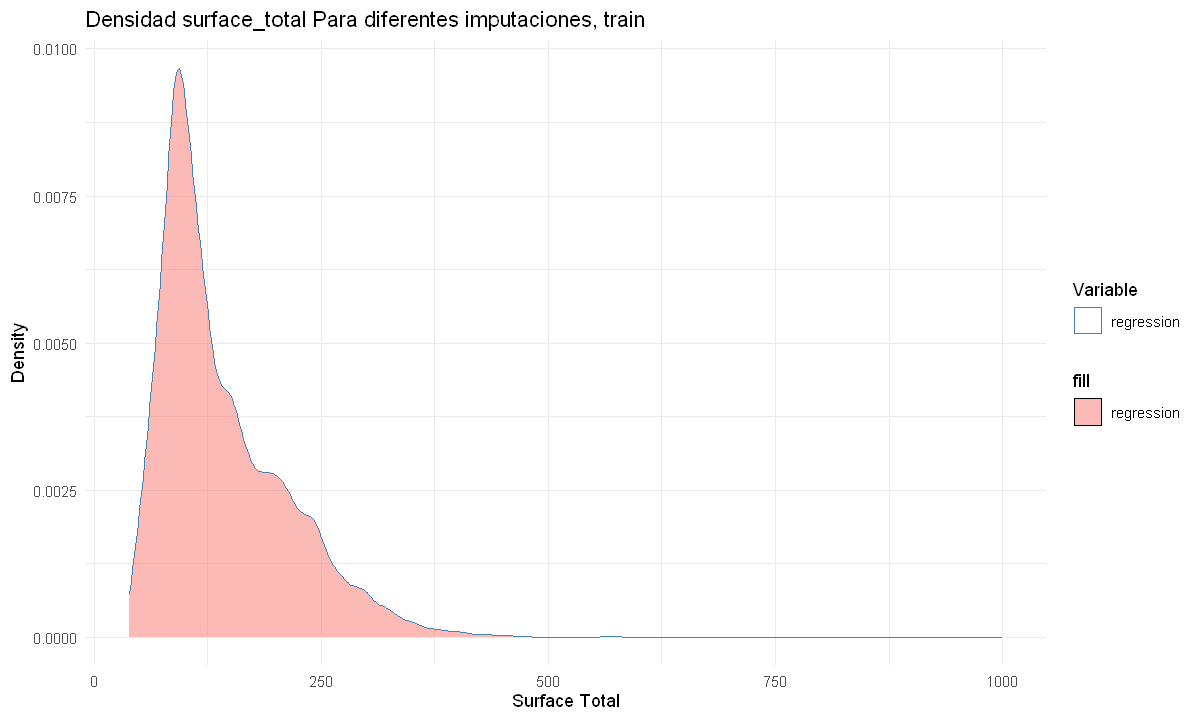

In [145]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = surface_total,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Total",
        y = "Density"
    ) +
    theme_minimal() 

Miramos nuevamente la distribucion del precio

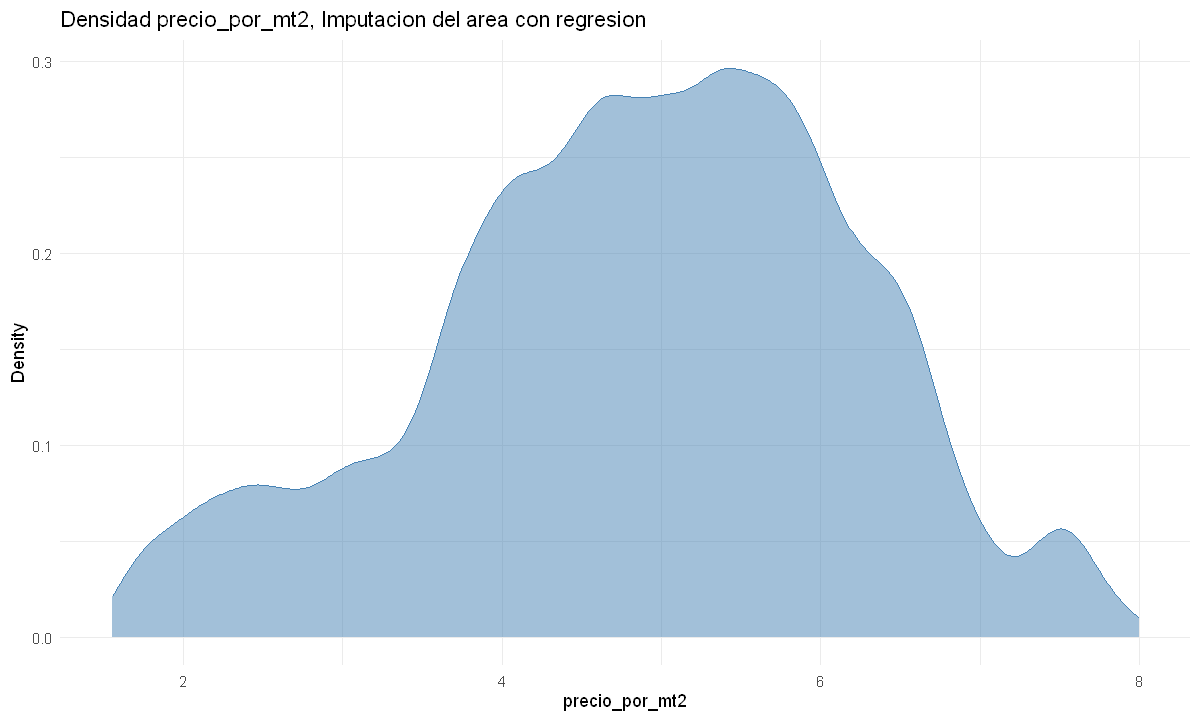

In [146]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con regresion",
        y = "Density"
    ) +
    theme_minimal() 

### Creamos Variables a partir de las disponibles

In [147]:
crear_variables <- function(data, train = TRUE){
  if (train){
    data <- data %>% 
      mutate(
        price_per_surface <- price/surface_total
      )
  }
  
  data <- data %>% 
    mutate(
      bathroom_per_bedroom = bathrooms/bedrooms,
      bathroom_per_room = bathrooms/rooms,
      ratio_covered = surface_covered/surface_total,
      bedroom_per_room = bedrooms/rooms
    )
  return(data)
}

train_reg <- crear_variables(train_reg, FALSE)
train_med <- crear_variables(train_med, FALSE)


Quitamos variables auxiliares

In [148]:
train_reg <- train_reg %>% 
  select(
    -c(
      pred_total,
      pred_covered,
    )
  )

test_reg <- test_reg %>% 
  select(
    -c(
      pred_total,
      pred_covered,
    )
  )

  head(train_reg)


,property_id,city,price,month,year,surface_total,surface_covered,rooms,bedrooms,bathrooms,⋯,operation_type,lat,lon,title,description,precio_por_mt2,bathroom_per_bedroom,bathroom_per_room,ratio_covered,bedroom_per_room
,<chr>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4fa04a187235d7509a43a8cf,Bogotá D.C,5.8e+08,10,2020,180.6663,206.7014,3,3,13,⋯,Venta,4.707211,-74.09965,de casa en los cerezos,cod 2901fr461 de casa multifamiliar 4 pisos garaje y local ubicado sector de los cerezos localidad de engativa agradable vista exterior cuenta con dos terrazas para compartir y disfrutar a una adecuada altura para apreciar la ciudad tiene muy buenos acabados la casa cuenta con 3 apartaestudios cada uno cuenta con su cocina totalmente amoblada y un bano la casa cuenta en total con 5 banos un banos en cada apartaestudio uno en garaje y otro en el local sala comedor con buenos espacios ademas de eso cuenta con 2 terrazas para disfrutar un bbq 3 apartaestudios totalmente independientes local totalmente independiente ubicacion con acceso cerca a la calle 80 a pocas cuadras de av cali o av cra 86 centros comerciales portal 80 y titan restaurantes parques cercanos colegios y universidades,3.210338,4.333333,4.3333333,1.144106,1.0000000
2,f9cfbb306af543a759c1f3f2,Bogotá D.C,6.0e+08,10,2020,304.3739,329.0327,9,9,13,⋯,Venta,4.612200,-74.13164,casa en floralia bogota,casa en o en el barrio floralia en la ciudad de bogota consta de pisos construidos 2 area construida 260 mts terraza 140 mts X s casa completa X piso X piso X piso 1 sala comedor cocina 4 dormitorios 3 banos patio de ropas cubierto 3 garajes cubiertos piso 2 sala comedor cocina tipo americano 5 dormitorios 2 banos 4 closets terraza zona de ropas deposito su ubicacion estrategica permite contar con transporte publico cercano colegios tiendas multiproposito y mucho mas,1.971259,1.444444,1.4444444,1.081015,1.0000000
3,eb32d75b32bc5e8677207fc7,Bogotá D.C,8.0e+08,10,2020,267.8363,292.4311,6,6,13,⋯,Venta,4.678147,-74.14215,casa fontibon a media cuadra de avda ferrocarril,oportunidad salio a la una amplia casa rentable en uno de los mejores sectores de fontibon en bogota rodeada de comercio y edificios residenciales sobre calle amplia a solo media cuadra de la avenida el ferrocarril posee local comercial amplio sobre la via 2 apartaestudios rentando ya alquilados con una alcoba bano y cocineta cada uno adicionalmente la propia casa posee 3 alcobas 1 bano 5 espacios de parqueo para 3 carros y 2 motos de los cuales solo 1 carro tendria servidumbre de parqueo los demas vehiculos quedan libres la casa tiene adicionalmente 2 estudios 2 bodegas patio de ropas cocina sala y comedor independientes y 1 aljibe el tamano del lote es de 316 m2 y sus dimensiones son 14 metros de frente x 22 metros de fondo el uso de suelo es mixto y a la propiedad puede darsele uso comercial y residencial estrato 3 direccion carrera 103 a 2246 fontibon zona 9 bogota ano de construccion 1946 de XXX casas ideal para supermercado u hotel en fontibon bogota el uso de suelo es mixto y a la propiedad puede darsele uso comercial y residencial estrato 3 sobre la misma cuadra y acera se encuentran construidos recientemente 2 edificios en cada esquina de 5 pisos cada uno y ambos con sotano y semisotano casas ideal para supermercado u hotel en fontibon bogota,2.986899,2.166667,2.1666667,1.091828,1.0000000
4,880a6e7bd74dc2568940d275,Bogotá D.C,4.8e+08,10,2020,173.3283,176.1723,11,3,3,⋯,Venta,4.756503,-74.05155,casa en bogota villa del prado,casa villa del prado amplia estilo asturiana muy iluminada tres alcobas estudio sala con chimenea comedor estudio cuarto y bano del servicio cocina patio de ropas cubierto antejardin garaje doble lote independiente celaduria informes juan rodriguez,2.769312,1.000000,0.2727273,1.016409,0.2727273
5,847cf8c0907ac512c8a0fc74,Bogotá D.C,8.0e+08,10,2020,175.0000,253.0000,5,5,3,⋯,Venta,4.703000,-74.05700,casa en en bogota malibu cod 

### Guardamos bases de datos provisionales

In [149]:
saveRDS(train_reg, file =  "stores\\provisionales\\train_reg.rds")
saveRDS(train_med,  file = "stores\\provisionales\\train_median.rds")

saveRDS(test_reg, file =  "stores\\provisionales\\test_reg.rds")
saveRDS(test_med,  file = "stores\\provisionales\\test_median.rds")